<a href="https://colab.research.google.com/github/1900690/koukai/blob/main/mite_demo_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#写真の撮り方

#アプリの使い方


1.   ”事前準備”と書いてあるところを一回クリック（もしくはタップ）しShift+Enter（もしくはスクリーンショット (3).pngをタップ)
2.   "画像を取り込み"の画像のアップロード方法を選択し、Shift+Enter（もしくはスクリーンショット (3).pngをタップ)
3.   ”検出を行う”と書いてあるところを一回クリック（もしくはタップ）しShift+Enter（もしくはスクリーンショット (3).pngをタップ)



In [ ]:
#@title 事前準備 { display-mode: "form" }
import shutil
import os
%cd -q '/content/'
# Download trained weights
!wget -q https://github.com/1900690/koukai/releases/download/mite_demo/mite_detect_3.zip
shutil.unpack_archive('/content/mite_detect_3.zip', '/content')
os.remove('/content/mite_detect_3.zip')
#★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
#tf用事前準備
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

TF_MODEL_FILE_PATH = '/content/model.tflite' # The default path to the saved TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)
classify_lite = interpreter.get_signature_runner('serving_default')

def rot_cut(src_img, deg, center, size):
    rot_mat = cv2.getRotationMatrix2D(center, deg, 1.0)
    rot_mat[0][2] += -center[0]+size[0]/2 # -(元画像内での中心位置)+(切り抜きたいサイズの中心)
    rot_mat[1][2] += -center[1]+size[1]/2 # 同上
    return cv2.warpAffine(src_img, rot_mat, size)
  
import numpy as np
import cv2

def pil2cv(image):
    ''' PIL型 -> OpenCV型 '''
    new_image = np.array(image, dtype=np.uint8)
    if new_image.ndim == 2: # モノクロ
        pass
    elif new_image.shape[2] == 3: # カラー
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
    elif new_image.shape[2] == 4: # 透過
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGBA2BGRA)
    return new_image

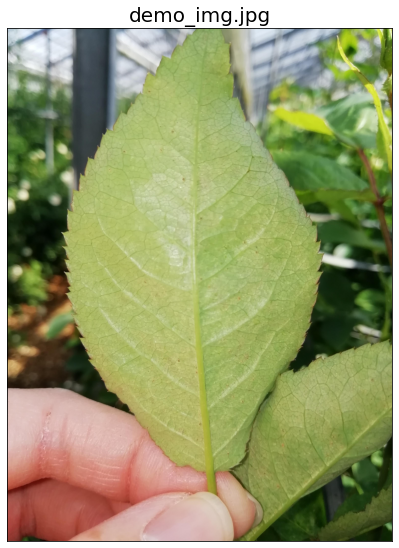

In [ ]:
#@title 画像を取り込み { display-mode: "form" }
画像のアップロード方法を選択してください= "\u30B5\u30F3\u30D7\u30EB\u753B\u50CF\u3067\u691C\u51FA" #@param ["サンプル画像で検出", "画像をアップロード", "インカメラで画像を撮影", "アウトカメラで画像を撮影"]

import os
import shutil
import datetime
dt_now = datetime.datetime.now()
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
from glob import glob
import matplotlib.pyplot as plt
#表示用関数定義
def show_images_glob(images, figsize=(40,20), columns = 5):
  plt.figure(figsize=figsize)
  for i, image in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.title(image[24:], loc='center',fontsize=20)
      plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False,bottom=False, left=False, right=False, top=False)
      plt.imshow(cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB))
#インカメラ用関数定義
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.facingMode ='user';
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

#アウトカメラ用関数定義
def take_photo_out(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video:{facingMode:{exact:"environment"}}});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.facingMode ='environment';
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


if 画像のアップロード方法を選択してください== "\u753B\u50CF\u3092\u30A2\u30C3\u30D7\u30ED\u30FC\u30C9" :
  if os.path.exists('/content/originals_test'):
    shutil.rmtree('/content/originals_test')

  if not os.path.exists('/content/originals_test/'):
      os.makedirs('/content/originals_test/')

  %cd -q '/content/originals_test/'

  from google.colab import files
  uploaded = files.upload()

  SOURCE_IMAGES = "/content/originals_test"
  FILE_PATTERN = "*.jpg" #ワイルドカードでフィルタリング
  images = glob(os.path.join(SOURCE_IMAGES, FILE_PATTERN))

  show_images_glob(images)

elif 画像のアップロード方法を選択してください== "\u30B5\u30F3\u30D7\u30EB\u753B\u50CF\u3067\u691C\u51FA":
    if os.path.exists('/content/originals_test'):
      shutil.rmtree('/content/originals_test')

    if not os.path.exists('/content/originals_test/'):
      os.makedirs('/content/originals_test/')
    
    shutil.copy('/content/mite_detect_1/yolov7/figure/demo_img.jpg','/content/originals_test/demo_img.jpg')

    SOURCE_IMAGES = "/content/originals_test"
    FILE_PATTERN = "*.jpg" #ワイルドカードでフィルタリング
    images = glob(os.path.join(SOURCE_IMAGES, FILE_PATTERN))

    show_images_glob(images)
elif 画像のアップロード方法を選択してください== "\u30A4\u30F3\u30AB\u30E1\u30E9\u3067\u753B\u50CF\u3092\u64AE\u5F71":
    #if os.path.exists('/content/originals_test'):
    #  shutil.rmtree('/content/originals_test')

    if not os.path.exists('/content/originals_test/'):
      os.makedirs('/content/originals_test/')
    
    %cd -q '/content'

    from IPython.display import Image
    try:
      filename = take_photo()
      title=dt_now.strftime('%Y%m%d_%H%M%S_000')

      #print('Saved to {}'.format(title+".jpg"))
      
      # Show the image which was just taken.
      #display(Image(filename))
    except Exception as err:
      # Errors will be thrown if the user does not have a webcam or if they do not
      # grant the page permission to access it.
      print(str(err))
    shutil.move('/content/photo.jpg', '/content/originals_test/'+title+".jpg")
    SOURCE_IMAGES = "/content/originals_test"
    FILE_PATTERN = "*.jpg" #ワイルドカードでフィルタリング
    images = glob(os.path.join(SOURCE_IMAGES, FILE_PATTERN))

    show_images_glob(images)
else:
      #if os.path.exists('/content/originals_test'):
    #  shutil.rmtree('/content/originals_test')

    if not os.path.exists('/content/originals_test/'):
      os.makedirs('/content/originals_test/')
    
    %cd -q '/content'

    from IPython.display import Image
    try:
      filename = take_photo_out()
      title=dt_now.strftime('%Y%m%d_%H%M%S_000')

      #print('Saved to {}'.format(title+".jpg"))
      
      # Show the image which was just taken.
      #display(Image(filename))
    except Exception as err:
      # Errors will be thrown if the user does not have a webcam or if they do not
      # grant the page permission to access it.
      #print(str(err))
      print("")
    if not os.path.exists('/content/photo.jpg'):
        print("アウトカメラがありません")
    else:
      shutil.move('/content/photo.jpg', '/content/originals_test/'+title+".jpg")
      SOURCE_IMAGES = "/content/originals_test"
      FILE_PATTERN = "*.jpg" #ワイルドカードでフィルタリング
      images = glob(os.path.join(SOURCE_IMAGES, FILE_PATTERN))

      show_images_glob(images)


  0%|          | 0/100 [elapsed: 00:00 remaining: ?]

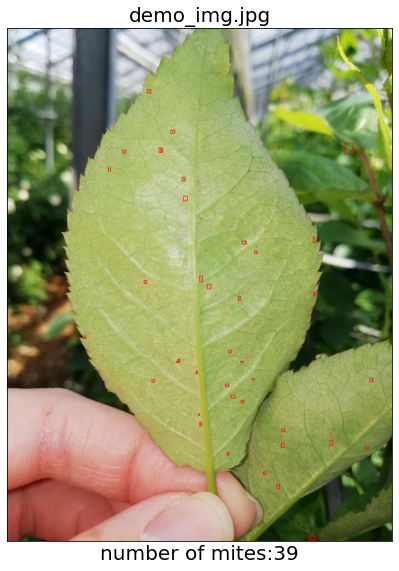

In [78]:
#@title 検出を行う { display-mode: "form" }

#prigresber用import
from IPython.utils import io
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:

      split_x=20
      split_y=20

      import cv2
      import numpy as np
      import os
      import shutil
      import pickle

      if not os.path.exists('/content/originals_test'):
        shutil.unpack_archive('/content/originals_test.zip', '/content')

      #'NoneType' object is not subscriptableといわれるので先にipynb_checkpointsを消す
      !rm -rf `find -type d -name .ipynb_checkpoints`

      #画像の読み込み
      read_files_name='/content/originals_test/'
      read_files = os.listdir(read_files_name)

      for file_name in read_files:
        fname = read_files_name+file_name #画像ファイル名
        foldaname=fname[9:]


        #img = np.array(Image.open(fname))  
        img=cv2.imread(fname,cv2.IMREAD_COLOR)
        #画像分割先のフォルダを作成
        if not os.path.exists('/content/split_pic_original/'+file_name[:-4]):
          os.makedirs('/content/split_pic_original/'+file_name[:-4])


        #画像の読み込み
        h,w=img.shape[:2]

        #画像の分割処理
        cx=0
        cy=0
        for j in range(split_x):
            for i in range(split_y):
                split_pic=img[cy:cy+int(h/split_y),cx:cx+int(w/split_x),:]
                
                with open(("/content/split_pic_original/"+file_name[:-4]+"/"+file_name[:-4]+'_y'+str('{0:02d}'.format(int(i)))+'_x'+str('{0:02d}'.format(int(j)))+foldaname[-4:])[:-4]+".pickle", 'wb') as f:
                  pickle.dump(split_pic, f)
              
                #★cv2.imwrite("/content/split_pic_original/"+file_name[:-4]+"/"+file_name[:-4]+'_y'+str('{0:02d}'.format(int(i)))+'_x'+str('{0:02d}'.format(int(j)))+foldaname[-4:],split_pic)
                cy=cy+int(h/split_y)
            cy=0
            cx=cx+int(w/split_x)

        #分割する線を描いた画像を出力
        y_step=int(h/split_y) #縦の分割間隔
        x_step=int(w/split_x) #横の分割間隔

        #オブジェクトimgのshapeメソッドの1つ目の戻り値(画像の高さ)をimg_yに、2つ目の戻り値(画像の幅)をimg_xに
        #img_y,img_x=img.size
        img_y,img_x=img.shape[:2]  

        #横線を引く：y_stepからimg_yの手前までy_stepおきに白い(BGRすべて255)横線を引く
        img[y_step:img_y:y_step, :, :] = 0
        #縦線を引く：x_stepからimg_xの手前までx_stepおきに白い(BGRすべて255)縦線を引く
        img[:, x_step:img_x:x_step, :] = 0

        cv2.imwrite("/content/split_pic_original/"+file_name[:-4]+"grid"+foldaname[-4:],img) #ファイル名'grid.png'でimgを保存
      pbar.update(8)
      #★★★★★★★★★★
      import glob
      if not os.path.exists('/content/originals_grid/'):
          os.makedirs('/content/originals_grid/')

      originals=('/content/split_pic_original/*.jpg')
      read_files = glob.glob(originals)

      for i in read_files:
        shutil.copy(i, '/content/originals_grid/')
      pbar.update(10)
      #★★★★★★★★★★
      #画像サイズを640にアップサンプリング
      import cv2
      import glob
      import os

      if not os.path.exists('/content/originals_upsamples/'):
        os.makedirs('/content/originals_upsamples/')

      read_folda_name='/content/split_pic_original/'
      read_folda = os.listdir(read_folda_name)

      for image_folda_name in read_folda:
        originals=('/content/split_pic_original/'+image_folda_name+'/*')
        read_files = glob.glob(originals)

        for imgpass in read_files:
          # 読み込む画像を選択
          with open(imgpass, 'rb') as f:
              img = pickle.load(f)
          #★img = cv2.imread(imgpass)
          h,w=img.shape[:2]
          # サイズ設定｜cv2では(幅、高さ）の順で数値を設定
          size = (w*5,h*5) 
          # 画像拡大・縮小 オプションで拡大計算式変更可能
          img_inter_area  = cv2.resize(img,size,interpolation = cv2.INTER_LINEAR) 
          #保存
          #with open('/content/originals_upsamples/'+os.path.split(imgpass)[1], 'wb') as f:
          #    pickle.dump(img_inter_area, f)
          cv2.imwrite('/content/originals_upsamples/'+os.path.split(imgpass)[1][:-7]+".bmp",img_inter_area)
      pbar.update(2)
      #★★★★★★★★★★
      #検出

      if os.path.exists('/content/detect_output'):
        shutil.rmtree('/content/detect_output')

      %cd -q '/content/mite_detect_1/yolov7'
      !python detect.py \
        --weights /content/mite_detect_1/yolov7/weights/best.pt \
        --conf 0.42 \
        --source '/content/originals_upsamples' \
        --name '/content/detect_output' \
        --save-txt \
        --save-conf
      pbar.update(40)
      #★★★★★★★★★★
      import pandas as pd
      import os
      import shutil
      from PIL import Image

      if os.path.exists('/content/originals_test_annotations/'):
        shutil.rmtree('/content/originals_test_annotations/')
      #if os.path.exists('/content/originals_test_annotations_yolotype/'):
      #  shutil.rmtree('/content/originals_test_annotations_yolotype/')

      yolo_pass="/content/originals_test_annotations/"
      if not os.path.exists(yolo_pass):
          os.mkdir(yolo_pass)

      #yolo_pass_yolotype="/content/originals_test_annotations_yolotype/"
      #if not os.path.exists(yolo_pass_yolotype):
      #    os.mkdir(yolo_pass_yolotype)

      read_files_name_bbox='/content/detect_output/labels/*'
      read_files_bbox = glob.glob(read_files_name_bbox)


      for txt_name in read_files_bbox:
        txt_file = pd.read_csv(txt_name,header=None, sep=" ")
        for i in range(len(txt_file[0])):
          im = Image.open('/content/detect_output/'+txt_name[30:-4]+".bmp")
          im_original = Image.open('/content/originals_test/'+txt_name[30:-12]+".jpg")
          image_width,image_height=np.array(im).shape[:2]
          image_width_original,image_height_original=np.array(im_original).shape[:2]
          name=txt_name[30:]
          y_number=int(txt_name[-10:-8])
          x_number=int(txt_name[-6:-4])

          x_center=float(txt_file[1][i])*image_height
          y_center=float(txt_file[2][i])*image_width
          width=float(txt_file[3][i])*image_height
          height=float(txt_file[4][i])*image_width

          x1=(x_center-height/2)
          y1=(y_center-width/2)
          x2=(x_center+height/2)
          y2=(y_center+width/2)
          #x1=(x_center-width/2)
          #y1=(y_center-height/2)
          #x2=(x_center+width/2)
          #y2=(y_center+height/2)

          x_min_original=x1+image_height*x_number
          y_min_original=y1+image_width*y_number
          x_max_original=x2+image_height*x_number
          y_max_original=y2+image_width*y_number


          absolute_x_original=x_min_original+(x_max_original-x_min_original)/2
          absolute_y_original=y_min_original+(y_max_original-y_min_original)/2
          absolute_width_original=x_max_original-x_min_original
          absolute_height_original=y_max_original-y_min_original
          #tfliteで判定★★★★★★★★★★★★★★★★★★★★
          cutimage_original=rot_cut(pil2cv(Image.open('/content/originals_test/'+txt_name[36:-4]+".jpg")), 0,(int(x_center),int(y_center)), (192,192))
          img_array = tf.expand_dims(tf.keras.utils.img_to_array(cutimage_original), 0) # Create a batch
          predictions_lite = classify_lite(rescaling_9_input=img_array)['dense_11']#判定
          score_lite = tf.nn.softmax(predictions_lite)#スコアを抽出
          tf_score=class_names[np.argmax(score_lite)]
          #★★★★★★★★★★★★★★★★★★★★

          col1="0"#str(tf_score)#
          col2=str(absolute_x_original / (image_height_original*5))
          col3=str(absolute_y_original / (image_width_original*5))
          col4=str(absolute_height_original / (image_height_original*5))
          col5=str(absolute_width_original / (image_width_original*5))


          col6=str(txt_file[5][i])
          col7=str(txt_name[30:-4])

          col8=str(int(absolute_x_original/5))
          col9=str(int(absolute_y_original/5))

          with open(yolo_pass+txt_name[30:-12]+'.txt', 'a') as f:
              rote=col1+' '+col2+' '+col3+' '+col4+' '+col5+' '+col6+' '+col7+' '+col8+' '+col9+'\n'
              f.write(rote)
      #    with open(yolo_pass_yolotype+txt_name[30:-12]+'grid.txt', 'a') as f:
      #        rote=col1+' '+col2+' '+col3+' '+col4+' '+col5+'\n'
      #        f.write(rote)
      pbar.update(20)
      #★★★★★★★★★★
      from PIL import Image, ImageDraw

      folda_pass="/content/originals_test_annotations_drawing"
      if not os.path.exists(folda_pass):
          os.mkdir(folda_pass)

      read_files_name_bbox='/content/originals_test_annotations/*'
      read_files_bbox = glob.glob(read_files_name_bbox)

      for txt_name in read_files_bbox:
        im_original = Image.open('/content/originals_test/'+txt_name[36:-4]+".jpg")
        image_width,image_height=np.array(im_original).shape[:2]

        txt_file = pd.read_csv('/content/originals_test_annotations/'+txt_name[36:-4]+".txt",header=None, sep=" ")
        for annotation in range(len(txt_file)):

          x_center=float(txt_file[1][annotation])*image_height
          y_center=float(txt_file[2][annotation])*image_width
          #★ここでx,yを使って切り取り計算するとよい★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


          width=float(txt_file[3][annotation])*image_height
          height=float(txt_file[4][annotation])*image_width
          #width=float(txt_file[3][annotation])*image_width
          #height=float(txt_file[4][annotation])*image_height

          #x1=int(x_center-height/2)
          #y1=int(y_center-width/2)
          #x2=int(x_center+height/2)
          #y2=int(y_center+width/2)
          x1=(x_center-width/2)
          y1=(y_center-height/2)
          x2=(x_center+width/2)
          y2=(y_center+height/2)

          #print(txt_name[36:-4],x_center,y_center,txt_file[5][annotation])

          draw = ImageDraw.Draw(im_original)
          draw.rectangle((x1, y1, x2, y2), outline=(255, 0, 0), width=5)
          im_original.save('/content/originals_test_annotations_drawing/'+txt_name[36:-4]+'.jpg')
          #im_original = Image.open('/content/originals_test_annotations_drawing/'+txt_name[36:-4]+".jpg")
      pbar.update(20)
      #★★★★★★★★★★
      #画像表示
      import cv2
      from glob import glob
      import matplotlib.pyplot as plt
      import os
      import subprocess

      def show_images_glob(images, figsize=(40,20), columns = 5):
        plt.figure(figsize=figsize)
        for i, image in enumerate(images):
            annotation_number=str(subprocess.check_output(['wc', '-l', '/content/originals_test_annotations/'+image[44:-4]+'.txt']).decode().split(' ')[0])
            plt.subplot(len(images) / columns + 1, columns, i + 1)
            plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False,bottom=False, left=False, right=False, top=False)
            plt.title(image[44:], loc='center',fontsize=20)
            plt.xlabel("number of mites:"+annotation_number,fontsize=20)
            plt.imshow(cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB))

except subprocess.CalledProcessError:
  print(captured)
  raise

SOURCE_IMAGES = "/content/originals_test_annotations_drawing"
FILE_PATTERN = "*.jpg" #ワイルドカードでフィルタリング
images = glob(os.path.join(SOURCE_IMAGES, FILE_PATTERN))

show_images_glob(images)

In [ ]:
txt_file = pd.read_csv('/content/originals_test_annotations/demo_img.txt',header=None, sep=" ")

In [ ]:
txt_file

,0,1,2,3,4,5,6,7,8
0,0,0.716282,0.813798,0.008974,0.009615,0.832031,demo_img_y16_x14,2234,3385
1,0,0.578622,0.631202,0.008269,0.006731,0.875488,demo_img_y12_x11,1805,2625
2,0,0.525256,0.505288,0.010385,0.010096,0.877441,demo_img_y10_x10,1638,2101
3,0,0.945769,0.686707,0.008462,0.008125,0.592773,demo_img_y13_x18,2950,2856
4,0,0.611122,0.728702,0.008782,0.005673,0.577637,demo_img_y14_x12,1906,3031
5,0,0.202692,0.603510,0.005385,0.006346,0.585938,demo_img_y12_x04,632,2510
6,0,0.397083,0.239351,0.005833,0.010144,0.587891,demo_img_y04_x07,1238,995
7,0,0.492596,0.672019,0.004808,0.006538,0.669922,demo_img_y13_x09,1536,2795
8,0,0.446154,0.648005,0.005769,0.003894,0.749023,demo_img_y12_x08,1392,2695
9,0,0.797276,0.414183,0.005449,0.012885,0.468750,demo_img_y08_x15,2487,1723
